In [ ]:
import numpy as np
import cv2
import pathlib
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
IMAGE_SHAPE = (224, 224)

!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip -d data_sets
data_dir = pathlib.Path("data_sets/cats_and_dogs_filtered/train")

replace data_sets/cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
list(data_dir.glob('*/*.jpg'))[:50]
image_count = len(list(data_dir.glob('*/*.jpg')))

catDogs_images_dict = {
    'Cat': list(data_dir.glob('cats/*.jpg')),
    'Dog': list(data_dir.glob('dogs/*.jpg'))
}

catDogs_labels_dict = {
    'Cat': 0,
    'Dog': 1,
}

In [ ]:
X, y = [], []

for label_name, images in catDogs_images_dict.items():
    for image_path in images:
        img = cv2.imread(str(image_path))
        if img is None:
            print(f"Aviso: falha ao ler {image_path}")
            continue

        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        elif img.shape[2] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)

        resized_img = cv2.resize(img, IMAGE_SHAPE)
        X.append(resized_img)
        y.append(catDogs_labels_dict[label_name])

In [ ]:
X = np.array(X, dtype='float32')
y = np.array(y)
X = preprocess_input(X)

print(f"Total de imagens processadas: {len(X)}")
print(f"Shape de uma imagem: {X[0].shape}")

Total de imagens processadas: 2000
Shape de uma imagem: (224, 224, 3)


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE + (3,))
base_model.trainable = False

features = base_model.predict(X, batch_size=32)
features = features.reshape((features.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(features , y, test_size=0.2, random_state=42)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1005s 16s/step


In [ ]:
classifier = Sequential([
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classifier.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

loss, acc = classifier.evaluate(X_test, y_test)
print(f"Teste - Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7798 - loss: 22.4753 - val_accuracy: 0.9750 - val_loss: 0.4182
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.9655 - loss: 0.4140 - val_accuracy: 0.9688 - val_loss: 0.2664
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.9815 - loss: 0.1040 - val_accuracy: 0.9625 - val_loss: 0.1338
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9923 - loss: 0.0289 - val_accuracy: 0.9875 - val_loss: 0.0784
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9914 - loss: 0.0171 - val_accuracy: 0.9937 - val_loss: 0.0166
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accuracy: 0.9879 - loss: 0.0492 - val_accuracy: 0.9812 - val_loss: 0.1566
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9952 - loss: 0.0178 - val_accuracy: 0.9812 - val_loss: 0.1101
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9918 - loss: 0.0372 - val_accuracy: 0.9812 - 

In [ ]:
def extract_features(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
Tamanho do vetor de recursos: (25088,)


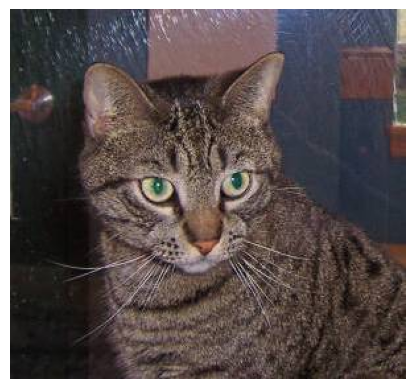

In [ ]:
import matplotlib.pyplot as plt
import cv2

img_path = 'data_sets/cats_and_dogs_filtered/train/cats/cat.1.jpg'
vector = extract_features(img_path)
print("Tamanho do vetor de recursos:", vector.shape)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()